In [42]:
import numpy as np
import matplotlib.pyplot as plt
from lammps import lammps 


class SimpleLammps():
    def __init__(self,N_D=55):
        self.N_D = N_D
        self.L = lammps(cmdargs=['-log','none','-screen','none'])
        """ 
            SUPER SIMPLE- MAKE A VACANCY THEN MOVE IT
        """ 
        self.L.commands_string(f"""
            units metal
            atom_style atomic
            atom_modify map array sort 0 0.0
            dimension 3
            timestep 0.001
            boundary p p p
            
            lattice bcc 3.18
            region C block 0 3 0 3 0 3 units lattice
            region mid block 2.4 2.6 2.4 2.6 2.4 2.6 units lattice
            create_box 1 C
            create_atoms 1 region C
            group mid region mid
            delete_atoms group mid
            
            mass * 184.0
            pair_style snap
            pair_coeff * * W.snapcoeff W.snapparam W
            
            fix seal all nve
            minimize  0 0 100 100
            write_data initial.dat

            compute dD all snad/atom 4.7 0.99363 8 0.5 1
            compute D all sna/atom 4.7 0.99363 8 0.5 1
            run 0
        """)
        self.D_i = self.get_D() # N x N_D
        self.X_i = self.get_X() # N x 3
        self.N = self.X_i.shape[0]
        self.W_i =  np.eye(N_D)#np.diag(1.0/np.sqrt(0.1+(self.get_D()**2).mean(0)))/self.N # N_D x N_D

        self.L.commands_string(""" 
            region sel block 2.9 3.1 2.9 3.1 2.9 3.1 units lattice
            group sel region sel
            displace_atoms sel move -0.5 -0.5 -0.5 units lattice
            minimize 0 0 100 100
            write_data final.dat
        """)
        self.D_f = self.get_D()
        self.X_f = self.get_X()
        print("In final vacancy configuration")

    def get_D(self):
        return np.ctypeslib.as_array(
            self.L.gather("c_D",1,self.N_D)).reshape((-1,self.N_D))

    def get_dD(self):
        """ snad/atom returns negative gradient !"""
        return -np.ctypeslib.as_array(
            self.L.gather("c_dD",1,3*self.N_D)).reshape((-1,3,self.N_D))

    def get_X(self):
        return np.ctypeslib.as_array(
            self.L.gather("x",1,3)).reshape((-1,3))
    
    def set_X(self,X):
        self.L.scatter("x",1,3,np.ctypeslib.as_ctypes(X.flatten()))
        self.L.command("run 0")

    def W_dot(self,X,Y,W=None):
        # X,Y : N x N_D, W: N_DxN_D
        if W is None:
            W = self.W_i # N_D x N_D
        return np.sum(X@W * Y)
    
    def W_matdot(self,dX,Y,W=None):
        if W is None:
            W = self.W_i # N_D x N_D
        # dX: Nx3xN_D, Y: NxN_D, W: N_DxN_D
        return np.einsum('ijk,ik->ij',dX,Y@W) #Nx3


    def get_loss(self,W=None,Di=None):
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        D_diff = self.get_D()-Di
        return 0.5 * self.W_dot(D_diff,D_diff,W)
    
    def get_loss_gradX(self,W=None,Di=None):
        """ 
            d/dX [D(X)-D_i].W.[D(X)-D_i]/2
            =
            dD(X).W.[]
        """ 
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        dX = np.einsum('ijk,ik->ij',self.get_dD(),(self.get_D()-Di)@W)
        dX -= dX.mean(0)[None,:]
        return dX
    
    def get_loss_angular(self,W=None,Di=None):
        """
        Angular loss:
        1 - |D(X).T W Di| / |D(X)|_W |Di|_W
        """
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        D = self.get_D()
        return 1-np.abs(self.W_dot(D,Di,W)) / np.sqrt(self.W_dot(D,D,W)*self.W_dot(Di,Di,W))
    
    def get_loss_gradX_angular(self,W=None,Di=None):
        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        D = self.get_D()
        dD = self.get_dD()
        DdotDi = self.W_dot(D,Di)
        dDdotDi = self.W_matdot(dD,Di)
        dDdotD = self.W_matdot(dD,Di)
        normD = np.sqrt(self.W_dot(D,D))
        normDi = np.sqrt(self.W_dot(Di,Di))

        return -(np.sign(DdotDi) * dDdotDi - np.abs(DdotDi) * dDdotD / normD**2) / (normD * normDi)
    
    def euler_steps(self,X,n=5,dt=0.005,W=None,Di=None):
        traj_hist = []
        loss_hist = []

        if W is None:
            W = self.W_i
        if Di is None:
            Di = self.D_i
        
        # to initial point
        self.set_X(X)
        X_i = X.copy()
        for step in range(n): 
            X = self.get_X()  
            traj_hist.append(X.copy())
            dX = self.get_loss_gradX_angular(W,Di)
            self.set_X(X - dX*dt)
            loss_hist.append(self.get_loss_angular())
            print(loss_hist[-1])
        
        return X_i,self.get_X(),dX,traj_hist,loss_hist


In final vacancy configuration
0.0028842618831527167
0.0028842620290077114
0.002884262174862595
0.002884262320717812
0.002884262466573362
0.0028842626124285786
0.0028842627582844615
0.0028842629041402335
0.0028842630499961164
0.0028842631958522214
0.0028842633417085484
0.0028842634875650974
0.0028842636334214244
0.0028842637792784176
0.0028842639251351887
0.002884264070992404
0.002884264216849397
0.0028842643627068343
0.0028842645085642715
0.00288426465442182
0.002884264800279923
0.0028842649461378045
0.002884265091995797
0.0028842652378541223
0.0028842653837125587
0.002884265529570884
0.0028842656754299867
0.0028842658212889782
0.0028842659671476367
0.0028842661130069613
0.002884266258866286
0.0028842664047258326
0.0028842665505856013
0.002884266696445481
0.0028842668423052498
0.0028842669881654626
0.0028842671340255643
0.002884267279885777
0.002884267425746434
0.002884267571607091
0.002884267717468414
0.002884267863329182
0.002884268009190283
0.002884268155051606
0.00288426830091304


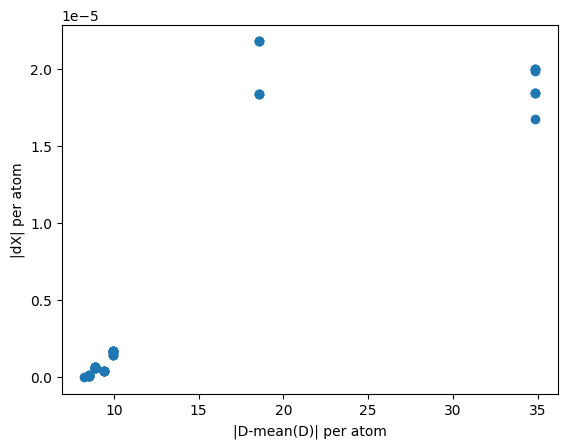

In [43]:
L = SimpleLammps()
X_i,X_f,dX,traj_hist,loss_hist=L.euler_steps(L.X_f,n=100,dt=1e-3)

D = L.get_D()
D -= D.mean(0)[None,:] # mean over box
plt.ylabel("|dX| per atom")
plt.xlabel("|D-mean(D)| per atom")
# expect |D|>0 for atoms where |dX| is small as they can be next to moving atoms
# i.e. points in bottom right but not top left
plt.scatter(np.linalg.norm(D,axis=1),np.linalg.norm(dX,axis=1))


In [44]:
from ase import Atoms
from ase.io import read,write

from ase.visualize import view

def read_ase(filename):
    
    return read(
        filename=filename, 
        format="lammps-data", 
        Z_of_type={1: 78}, 
        style="atomic"
    )

atom_ini = read_ase("initial.dat")
atom_fin = read_ase("final.dat")

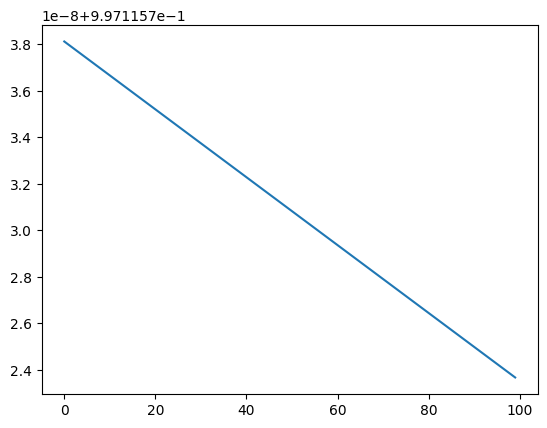

In [39]:
plt.plot(loss_hist)

In [46]:
from copy import deepcopy
traj_ase = [atom_fin]
tmp = deepcopy(atom_fin)

for pos in traj_hist:
    tmp.positions=pos
    traj_ase.append(deepcopy(tmp))

view(traj_ase)